In [1]:
import pyvisa
import numpy as np
import tables as pt
import matplotlib.pyplot as plt  
import csv
import datetime, time

rm = pyvisa.ResourceManager("@py")
ports = rm.list_resources()
device = rm.open_resource("ASRL/dev/cu.usbmodem1101::INSTR", read_termination="\r\n", write_termination="\n")
print(ports,device.query("*IDN?"))


('ASRL/dev/cu.RichardHP::INSTR', 'ASRL/dev/cu.Bluetooth-Incoming-Port::INSTR', 'ASRL/dev/cu.usbmodem1101::INSTR') Arduino VISA firmware v0.2


## Execute time-based measurement
I first make a heartbeat signal, hereafter I make a sinusoidal signal.

In [2]:
Tbegin = time.time()
Tend = Tbegin+10
T = Tbegin
while T < Tend:
    device.query(f"OUT:CH0 {1022}")
    time.sleep(.1)
    device.query("OUT:CH0 0")
    time.sleep(.1)
    device.query(f"OUT:CH0 {1022}")
    time.sleep(.1)
    device.query("OUT:CH0 0")
    time.sleep(1)
    T=time.time()
device.query("OUT:CH0 0")

T = Tbegin
while T < Tend:
    xlist = np.arange(0,2*np.pi,0.01)
    for i in range(len(xlist)):
        device.query(f"OUT:CH0 {int(1022*np.abs(np.sin(xlist[i])))}")
        time.sleep(.005)
    T=time.time()
device.query("OUT:CH0 0")

'0'

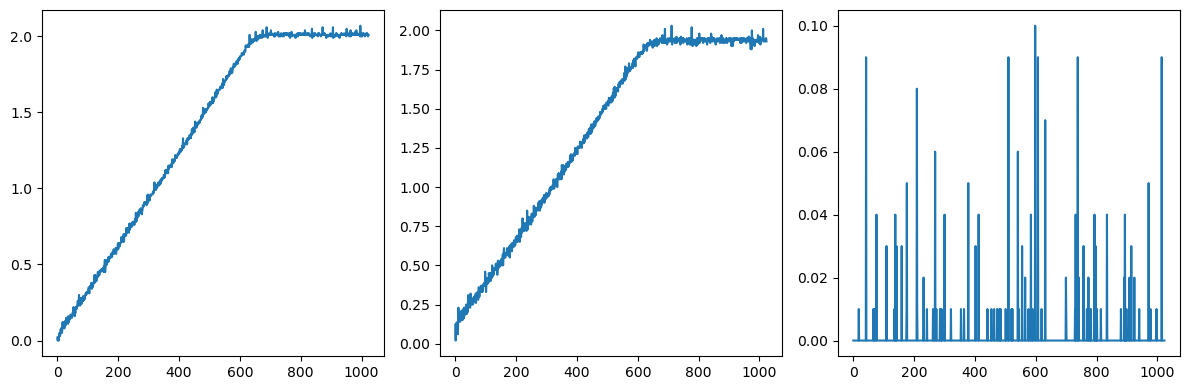

In [115]:
def volt_adc(number):
    v = number*3.3/1024
    return v
def adc_volt(number):
    adc= int(number*1024/3.3)
    return adc

V0list,V1list,V2list =[],[],[]
for i in range(1024):
    device.query(f"OUT:CH0 {i}")
    V0list.append(float(device.query("MEAS:CH0:VOLT?")))
    V1list.append(float(device.query("MEAS:CH1:VOLT?")))
    V2list.append(float(device.query("MEAS:CH2:VOLT?")))

fig,axes=plt.subplots(1,3,figsize=(12,4))
axes[0].plot(range(0,1024),np.asarray(V0list))
axes[1].plot(range(1024),V1list)
axes[2].plot(range(1024),V2list)
plt.tight_layout()


In [120]:
measurement = "blauwe_led_4"
with open(f"LED_curve_m{measurement}.csv",'w') as file:
    wr=csv.writer(file)
    Tbegin = time.time()
    
    Vinput,tlist = [],[]
    V0list,V1list,V2list = [],[],[]
    volt=0
    
    seconds = time.time()
    local_time = time.ctime(seconds)

    wr.writerow([str(local_time),"Experiment LED arduino 33IoT"])
    wr.writerow(["time(s)", "Vinput(V)", "V0","V1","V2"])

    while volt<3.3:
        V_input, V2,V1,V0 = device.query(f"OUT:CH0 {adc_volt(volt)}"),float(device.query("MEAS:CH2:VOLT?")),float(device.query("MEAS:CH1:VOLT?")),float(device.query("MEAS:CH0:VOLT?"))
        # print(V_input,V0,V1,V2)
        tlist.append(time.time()-Tbegin)
        Vinput.append(V_input)
        V0list.append(V0)
        V1list.append(V1)
        V2list.append(V2)
        wr.writerow([time.time()-Tbegin,V_input, V0,V1,V2])
        volt+=0.003
        
device.query("OUT:CH0 1000")
time.sleep(.5)
device.query("OUT:CH0 0")



'0'

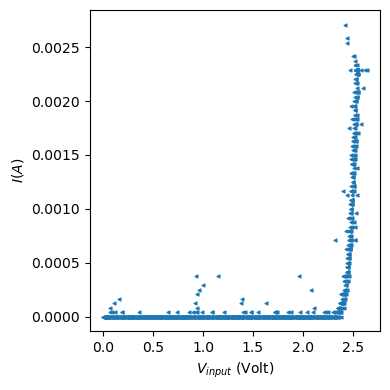

In [89]:
weerstand = 240
Vled = np.asarray(V1list)-np.asarray(V2list)
Stroomsterkte = np.asarray(V2list)/weerstand
fig,axes=plt.subplots(1,1,figsize=(4,4))
axes.set_xlabel('$V_{input}$ (Volt)')
axes.set_ylabel('$I (A)$')
axes.scatter(Vled,Stroomsterkte,s=4,marker='<')
# axes.set_xlim(1.5,2)
# axes.set_yscale('log')
plt.tight_layout()

In [94]:
from tables import *
class Particle(IsDescription):
    name      = StringCol(16)   # 16-character String
    idnumber  = Int64Col()      # Signed 64-bit integer
    ADCcount  = UInt16Col()     # Unsigned short integer
    TDCcount  = UInt8Col()      # unsigned byte
    grid_i    = Int32Col()      # 32-bit integer
    grid_j    = Int32Col()      # 32-bit integer
    pressure  = Float32Col()    # float  (single-precision)
    energy    = Float64Col()    # double (double-precision)
h5file = open_file("tutorial1.h5", mode="w", title="Test file")
group = h5file.create_group("/", 'detector', 'Detector information')

ValueError: The file 'tutorial1.h5' is already opened.  Please close it before reopening in write mode.

In [96]:
group = h5file.create_group("/", 'detector', 'Detector information')
table = h5file.create_table(group, 'readout', Particle, "Readout example")


NodeError: group ``/`` already has a child node named ``detector``

In [98]:
table = h5file.create_table(group, 'readout', Particle, "Readout example")


NodeError: group ``/detector`` already has a child node named ``readout``

In [102]:
particle = table.row
h5file

File(filename=tutorial1.h5, title='Test file', mode='w', root_uep='/', filters=Filters(complevel=0, shuffle=False, bitshuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) 'Test file'
/detector (Group) 'Detector information'
/detector/readout (Table(0,)) 'Readout example'
  description := {
  "ADCcount": UInt16Col(shape=(), dflt=0, pos=0),
  "TDCcount": UInt8Col(shape=(), dflt=0, pos=1),
  "energy": Float64Col(shape=(), dflt=0.0, pos=2),
  "grid_i": Int32Col(shape=(), dflt=0, pos=3),
  "grid_j": Int32Col(shape=(), dflt=0, pos=4),
  "idnumber": Int64Col(shape=(), dflt=0, pos=5),
  "name": StringCol(itemsize=16, shape=(), dflt=b'', pos=6),
  "pressure": Float32Col(shape=(), dflt=0.0, pos=7)}
  byteorder := 'little'
  chunkshape := (1394,)

In [106]:
for i in range(10):
    particle['name']  = f'Particle: {i:6d}'
    particle['TDCcount'] = i % 256
    particle['ADCcount'] = (i * 256) % (1 << 16)
    particle['grid_i'] = i
    particle['grid_j'] = 10 - i
    particle['pressure'] = float(i*i)
    particle['energy'] = float(particle['pressure'] ** 4)
    particle['idnumber'] = i * (2 ** 34)
    # Insert a new particle record
    particle.append()
table.flush()

In [112]:
table = h5file.root.detector.readout
h5file.close()